In [33]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
from sklearn.cluster import KMeans
import sqlite3

## **Función para lectura de datos**

Para empezar se cargarán los datos

In [2]:
def carga_datos_ventas(name_document):
    """
    Lectura de los datos a tráves de la librería de pandas.

    Args:
    name_document: Nombre del archivo que se va a leer.
    """

    df = pd.read_excel(name_document)
    return df


In [3]:
df = carga_datos_ventas("Techincal Test.xlsx")

In [4]:
df.head()

,NumeroOrden,Fecha,Identificacion,idProducto,Categoria,Marca,ValorTotalOrden,CantidadTotalOrden,PrecioUnitario,Cantidad
0,1434,2023-04-01,1256,1,1.0,001,79824,1,79823.53,1
1,1435,2023-04-01,1229,2,1.0,001,84025,1,84025.21,1
2,1436,2023-04-01,147,3,1.0,001,153765,2,78142.86,1
3,1436,2023-04-01,147,4,1.0,001,153765,2,75621.85,1
4,1437,2023-04-01,1257,5,1.0,031,59655,1,59655.46,1


In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   NumeroOrden         3300 non-null   int64         
 1   Fecha               3300 non-null   datetime64[ns]
 2   Identificacion      3300 non-null   int64         
 3   idProducto          3300 non-null   int64         
 4   Categoria           3296 non-null   float64       
 5   Marca               3296 non-null   object        
 6   ValorTotalOrden     3300 non-null   int64         
 7   CantidadTotalOrden  3300 non-null   int64         
 8   PrecioUnitario      3300 non-null   float64       
 9   Cantidad            3300 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 257.9+ KB


Se puede observar que solo existen 4 datos nulos, en la columna de marca y categoria para efectos de tener en cuenta los valores aportados
se eliminarán estas filas y se tendrá el valor total en cuenta.

# **Tratamiento de valores pérdidos**

Ahora se llevará a cabo un tratamiento de valores pérdidos

In [7]:
df_nan = df[df['Categoria'].isnull()]
df_nan

,NumeroOrden,Fecha,Identificacion,idProducto,Categoria,Marca,ValorTotalOrden,CantidadTotalOrden,PrecioUnitario,Cantidad
445,1806,2023-04-17,1601,170,NaN,NaN,322556,16,20159.66,4
497,1852,2023-04-18,1643,170,NaN,NaN,725748,36,20159.66,6
554,1903,2023-04-20,1690,170,NaN,NaN,725748,36,20159.66,6
2611,6018,2023-05-02,5386,170,NaN,NaN,18479,1,18478.99,1


In [8]:
df_nan['ValorTotalOrden'].sum()

1792531

In [9]:
df.dropna(inplace=True)

Cambiar la marca "  " por "000"

In [10]:
df['Marca'] = df['Marca'].replace('   ', '000')

# **Ahora se identificarán los outliers**

In [11]:
df.describe()

,NumeroOrden,Identificacion,idProducto,Categoria,ValorTotalOrden,CantidadTotalOrden,PrecioUnitario,Cantidad
count,3296.000000,3296.000000,3296.000000,3296.000000,3.296000e+03,3296.000000,3296.000000,3296.000000
mean,2994.003944,2592.028823,187.137743,4.208738,1.457846e+05,3.276396,52294.296826,1.267294
std,1093.284458,1052.634215,179.554555,16.000099,3.519569e+05,11.103093,28084.341926,0.835029
min,12.000000,10.000000,1.000000,1.000000,7.555000e+03,1.000000,0.000000,1.000000
25%,2134.750000,1831.750000,45.000000,1.000000,5.577425e+04,1.000000,33605.040000,1.000000
50%,2781.500000,2469.500000,123.000000,1.000000,8.065950e+04,2.000000,52092.440000,1.000000
75%,3833.250000,3370.750000,262.250000,2.000000,1.545880e+05,3.000000,72184.870000,1.000000
max,6025.000000,5391.000000,749.000000,99.000000,1.209748e+07,420.000000,185705.880000,20.000000


In [12]:
columnas_numericas = ['ValorTotalOrden', 'CantidadTotalOrden', 'PrecioUnitario', 'Cantidad']

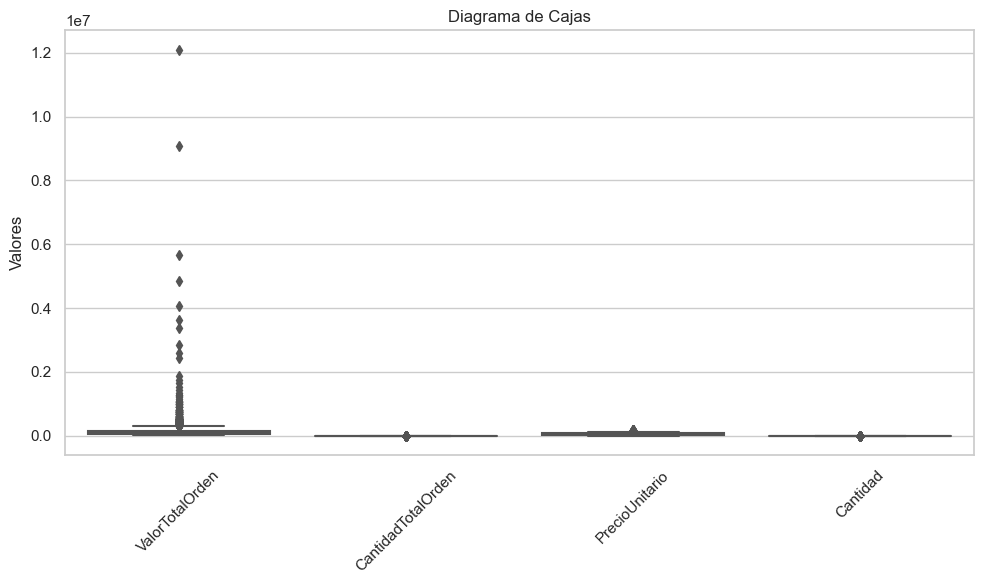

In [13]:

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[columnas_numericas], palette="muted")
plt.title('Diagrama de Cajas')
plt.ylabel('Valores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Para el diagrama de cajas se ven outliers para el valor total orden.

# **Agrupación por categoria y marca**

Calcular las ventas totales y las unidades totales vendidas para cada 
categoría y cada marca

In [14]:
df_marca= df.groupby("Marca", as_index=False)[['PrecioUnitario', 'ValorTotalOrden', 'CantidadTotalOrden', 'Cantidad']].sum()
df_marca.sort_values('ValorTotalOrden', ascending=False, inplace=True)

In [15]:
df_marca.head()

,Marca,PrecioUnitario,ValorTotalOrden,CantidadTotalOrden,Cantidad
1,001,61155403.87,163813318,3238,1217
10,031,20161133.97,53181222,1064,439
4,007,16495848.75,49916195,1373,531
5,019,17035050.37,40180117,668,279
0,000,5308595.79,37566371,1162,406


In [16]:
df_category = df.groupby("Categoria", as_index=False)[['PrecioUnitario', 'ValorTotalOrden', 'CantidadTotalOrden', 'Cantidad']].sum()
df_category.sort_values('ValorTotalOrden', ascending=False, inplace=True)

In [17]:
df_category

,Categoria,PrecioUnitario,ValorTotalOrden,CantidadTotalOrden,Cantidad
0,1.0,1.283242e+08,343544372,7709,3043
1,2.0,1.843645e+07,47246632,803,326
2,3.0,1.365529e+07,37680227,858,431
3,4.0,8.650222e+06,29113318,777,210
5,99.0,3.275706e+06,22901494,651,166
4,5.0,2.015966e+04,20160,1,1


Calcular el precio promedio para cada categoría

In [18]:
df_category_mean = df.groupby("Categoria", as_index=False)['PrecioUnitario'].mean()
df_category_mean.sort_values('PrecioUnitario', ascending=False, inplace=True)

In [19]:
df_category_mean

,Categoria,PrecioUnitario
1,2.0,57078.804025
0,1.0,55817.384950
3,4.0,51797.736228
5,99.0,35996.765934
2,3.0,32904.321277
4,5.0,20159.660000


In [20]:
df_producto = df.groupby("idProducto", as_index=False)[['PrecioUnitario', 'ValorTotalOrden', 'CantidadTotalOrden', 'Cantidad']].sum()
df_producto.sort_values('ValorTotalOrden', ascending=False, inplace=True)

In [21]:
df_producto

,idProducto,PrecioUnitario,ValorTotalOrden,CantidadTotalOrden,Cantidad
165,167,201630.24,18888380,409,91
324,455,2032890.09,14664877,511,240
78,79,443563.07,14027195,477,41
6,7,798092.42,12865234,460,67
37,38,2529050.59,9733872,190,69
...,...,...,...,...,...
388,584,27722.69,27723,1,1
247,259,20159.66,20160,1,1
343,479,17638.66,17639,1,1
421,660,15109.24,15110,2,2


# **Análisis EDA**

Se agrupan las marcas por la media de precio unitario

In [22]:
df_means = df.groupby("Marca", as_index=False)['PrecioUnitario'].mean()
df_means = df_means.sort_values('PrecioUnitario', ascending=False)

<Axes: xlabel='Marca', ylabel='PrecioUnitario'>

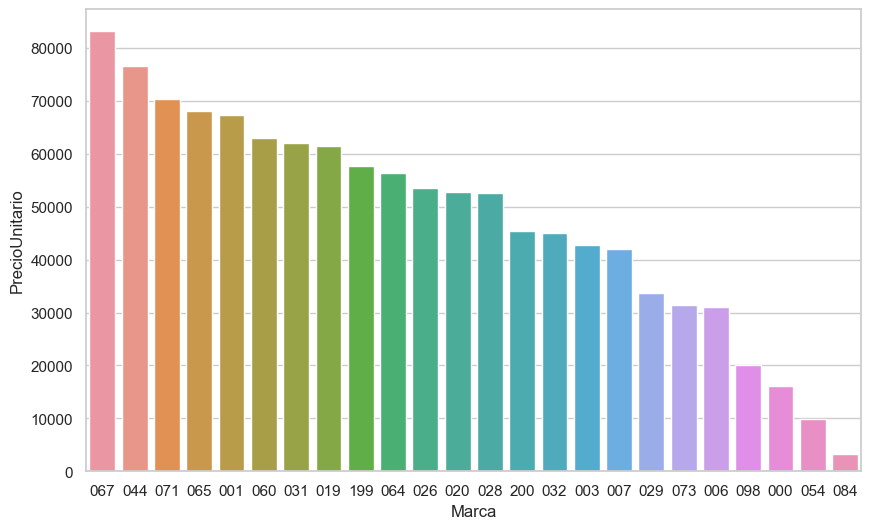

In [23]:
plt.figure(figsize=(10,6))
sns.barplot(x = 'Marca', y='PrecioUnitario', data = df_means )

c:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


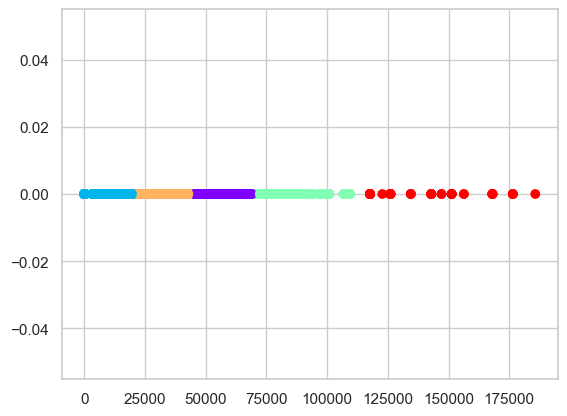

In [24]:
k_means = KMeans(n_clusters=5)
df['PrecioUnitarioCluster'] = k_means.fit_predict(df[['PrecioUnitario']])
plt.scatter(df['PrecioUnitario'],[0]*len(df),c=df['PrecioUnitarioCluster'],cmap='rainbow')

In [25]:
df_aux = df[df['CantidadTotalOrden'] <=4]

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_32120\1176787606.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_aux['CantidadTotalOrden'],df_aux['PrecioUnitario'],cmap='rainbow')


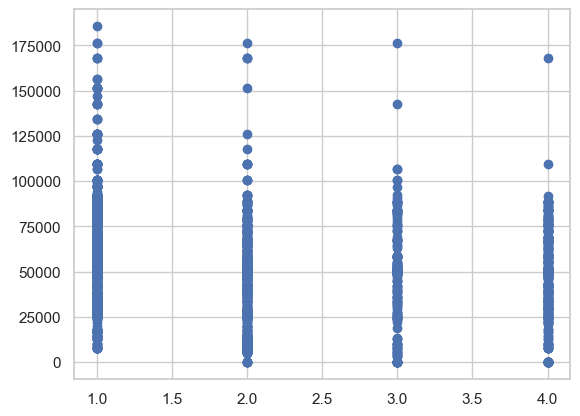

In [26]:
plt.scatter(df_aux['CantidadTotalOrden'],df_aux['PrecioUnitario'],cmap='rainbow')

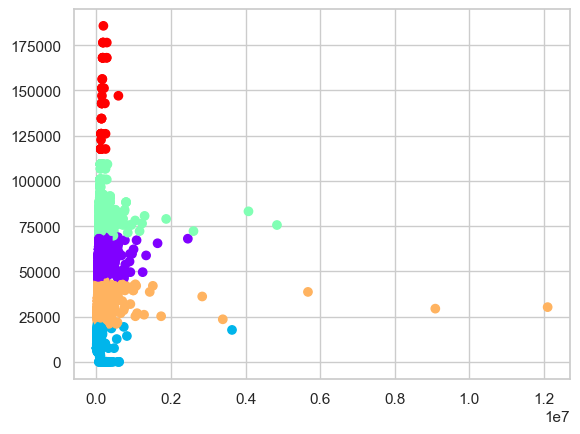

In [27]:
plt.scatter(df['ValorTotalOrden'],df['PrecioUnitario'],c=df['PrecioUnitarioCluster'],cmap='rainbow')

# **Modelo RFM**

Para este modelo se calcula Recency: Que tan recientemente el cliente ha realizado una compra,
Frecuencia: La frecuencia de compra del cliente. Monetary: El importe total gastado por el cliente, en un tiempo determinado. 

In [28]:
def calcular_rfm(df):
    
    """
    Calcula las métricas RFM (Recency, Frequency, Monetary) 

    Args:
    df: El DataFrame 

    Returns:
    pd.DataFrame: Un DataFrame que contiene las métricas RFM para cada cliente.

    La métrica de monetary se hace con la suma del valor total de la orden por cliente,
    teniendo en cuenta el rango de fechas presentes en los datos, y dividiendo este valor
    por el número de días.
    
    """
    df_ = df.copy()
    today = datetime.now()

    recency = df_.groupby('Identificacion')['Fecha'].max().reset_index()
    recency.columns = ['Identificacion', 'FechaUltimaTransaccion']
    recency['Recency'] = (today - recency['FechaUltimaTransaccion']).dt.days

    rango_fechas = (recency['FechaUltimaTransaccion'].max() - recency['FechaUltimaTransaccion'].min()).days

    frecuencia = df_.groupby('Identificacion')['Fecha'].count().reset_index()
    frecuencia.columns = ['Identificacion', 'Frecuencia']

    valor_monetario = df_.groupby('Identificacion')['ValorTotalOrden'].sum().reset_index()
    valor_monetario.columns = ['Identificacion', 'ValorMonetario']

    rfm_dataframe = pd.merge(recency, frecuencia, on='Identificacion')
    rfm_dataframe = pd.merge(rfm_dataframe, valor_monetario, on='Identificacion')

    rfm_dataframe['Monetary'] = rfm_dataframe['ValorMonetario'] / rango_fechas

    rfm_dataframe['RecenciaScore'] = pd.qcut(rfm_dataframe['Recency'], q=4, duplicates='drop')
    rfm_dataframe['FrecuenciaScore'] = pd.qcut(rfm_dataframe['Frecuencia'], q=4, duplicates='drop')
    rfm_dataframe['ValorMonetarioScore'] = pd.qcut(rfm_dataframe['Monetary'], q=4, duplicates='drop')

    rfm_dataframe['RecenciaScore'] = rfm_dataframe['RecenciaScore'].cat.codes + 1
    rfm_dataframe['FrecuenciaScore'] = rfm_dataframe['FrecuenciaScore'].cat.codes + 1
    rfm_dataframe['ValorMonetarioScore'] = rfm_dataframe['ValorMonetarioScore'].cat.codes + 1

    rfm_dataframe['RFM'] = rfm_dataframe['RecenciaScore'] + rfm_dataframe['FrecuenciaScore'] + rfm_dataframe['ValorMonetarioScore']

    return rfm_dataframe



In [29]:
df_rfm = calcular_rfm(df)

In [30]:
df_rfm

,Identificacion,FechaUltimaTransaccion,Recency,Frecuencia,ValorMonetario,Monetary,RecenciaScore,FrecuenciaScore,ValorMonetarioScore,RFM
0,10,2023-04-01,144,1,83185,1459.385965,4,1,2,7
1,11,2023-04-08,137,2,292404,5129.894737,4,1,4,9
2,12,2023-04-16,129,1,53773,943.385965,4,1,1,6
3,13,2023-04-24,121,1,45370,795.964912,3,1,1,5
4,14,2023-04-28,117,1,75622,1326.701754,3,1,2,6
...,...,...,...,...,...,...,...,...,...,...
2292,5384,2023-05-09,106,1,7555,132.543860,2,1,1,4
2293,5385,2023-05-13,102,1,7555,132.543860,1,1,1,3
2294,5389,2023-04-03,142,1,27723,486.368421,4,1,1,6
2295,5390,2023-04-03,142,1,30244,530.596491,4,1,1,6


In [37]:
df_rfm['Mes'] = df_rfm['FechaUltimaTransaccion'].dt.month

# **Ingestión bases de datos en SQLite3 para conexión en Power BI**

In [31]:
def ingestar_datos(df, BD = 'BaseGPX.bd', Tabla = 'Rutas'):
    conn = sqlite3.connect(BD)
    df.to_sql(Tabla, conn, if_exists='replace', index = False)
    df_consulta = pd.read_sql(f'SELECT * FROM {Tabla}', conn)
    conn.close()
    return df_consulta

In [40]:
ingestar_datos(df_marca, BD = 'BaseAgrupacionMarca.bd', Tabla = 'AgrupacionMarca')
ingestar_datos(df_category, BD = 'BaseAgrupacionCategoria.bd', Tabla = 'AgrupacionCategoria')
ingestar_datos(df_category_mean, BD = 'BaseCategoriaMedia.bd', Tabla = 'AgrupacionCategoriaMedia')
ingestar_datos(df_producto, BD = 'BaseProducto.bd', Tabla = 'Producto')
ingestar_datos(df_rfm, BD = 'BaseRFM.bd', Tabla = 'RFM')


,Identificacion,FechaUltimaTransaccion,Recency,Frecuencia,ValorMonetario,Monetary,RecenciaScore,FrecuenciaScore,ValorMonetarioScore,RFM,Mes
0,10,2023-04-01 00:00:00,144,1,83185,1459.385965,4,1,2,7,4
1,11,2023-04-08 00:00:00,137,2,292404,5129.894737,4,1,4,9,4
2,12,2023-04-16 00:00:00,129,1,53773,943.385965,4,1,1,6,4
3,13,2023-04-24 00:00:00,121,1,45370,795.964912,3,1,1,5,4
4,14,2023-04-28 00:00:00,117,1,75622,1326.701754,3,1,2,6,4
...,...,...,...,...,...,...,...,...,...,...,...
2292,5384,2023-05-09 00:00:00,106,1,7555,132.543860,2,1,1,4,5
2293,5385,2023-05-13 00:00:00,102,1,7555,132.543860,1,1,1,3,5
2294,5389,2023-04-03 00:00:00,142,1,27723,486.368421,4,1,1,6,4
2295,5390,2023-04-03 00:00:00,142,1,30244,530.596491,4,1,1,6,4
